<h1>CTA Data Pre_Processing and Plotting</h1>
<img src="./img/cta_banner.jpg" alt="CTA Banner">

<h1>Foreward</h1>
<p>The following is the code for the preprocessing/cleaning of the CTA ridership data.
This code also includes line charts for yearly El station entries and bus ridership and
yearly el Station entry and bus ridership figures by route/station, along with bar charts
for showing overall ridership/entry for all routes and stations</p>

<i> A careful observe might notice that my code might be a bit cleaner if I sorted the
datetime index prior to aggregating the data; however, this was a concious decision made
due to the fact that this would take to long to run on such a large set of data.</i>

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

<h3>Reading in the Data</h3>

In [95]:
# read in the bus and station data from csv files
el_station_entries = pd.read_csv('data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')
bus_ridership = pd.read_csv('data/CTA_-_Ridership_-_Bus_Routes_-_Daily_Totals_by_Route.csv')
el_station_entries.name = 'el_station_entries'
bus_ridership.name = 'bus_ridership'
dataframes = [el_station_entries, bus_ridership]

<h2>Cleaning the Data</h2>
<H3>Checking for Duplicate Entries and Missing Data</H3>
<p>We will start by removing duplicates and checking for missing entries. Let's 
also set our index to date for some plotting we'll be doing later.</p>

In [96]:
# set the index to date, drop duplicates and check for missing entries
for df in dataframes:
    print('\n' + df.name)
    
    df.set_index('date', inplace=True) # set index to date
    
    # display sum of duplicates and drop them from the dataframe
    print('duplicates removed: ' + str(sum(df.duplicated())))
    df.drop_duplicates(inplace=True)
    
    # check for missing entries (fortunately, there are none for these datasets)
    mask = df.isnull()
    missing = mask.sum(axis=0)
    
    print('\nmissing: ')
    print(missing)


el_station_entries
duplicates removed: 459219

missing: 
station_id     0
stationname    0
daytype        0
rides          0
dtype: int64

bus_ridership
duplicates removed: 299345

missing: 
route      0
daytype    0
rides      0
dtype: int64


<h3>Results</h3>
<p>It looks like we had to drop 459,219 duplicates from our el station data and
299,345 entries from our bus ridership data. It is not uncommon when working with
data that there will be duplicate entries for certain records. So, it's always
a good idea to check as one of your first steps in processing the data. 
Fortunately for us, there were no missing entries in our data. However, this is not
always the case. So it is crucial to check your data for this as an initial step as well.</p>

<h3>Removing non-descriptive Columns</h3>
<p>Next, it's always a good idea to remove columns that you're probably not going
to be using the data from, so as to expedite query execution. Since we won't need
the daytype for any of our analysis, we can drop that. And since we have stationid
to uniquely identify stations in our data, we'll drop stationname for now, after
creating a mapping of stationname to stationid. </p>

In [97]:
# maps station_ids to stationnames
station_mapping = el_station_entries[['station_id','stationname']].drop_duplicates()
station_dict = {}

# turn mapping into a dict
for mapping in station_mapping.iterrows():
    station_dict[mapping[1]['station_id']] = mapping[1]['stationname']

# remove columns that don't provide information that is useful to our analysis
l_station_entries_cl = l_station_entries.drop(['stationname', 'daytype'], axis=1)
bus_ridership_cl = bus_ridership.drop('daytype', axis=1)
clean_dfs = [l_station_entries_cl, bus_ridership_cl]

<h2>Aggregating the Data</h2>
<p>We can now group our data in different ways. First, we will group the data so
that we can see how many times the el and the buses were ridden in a given year.</p>

In [98]:
# group by dates to get sums for each date (this step is provided so as to decrease number of
# computations when the index is converted to a datetime object later)
bus_sum_by_date = bus_ridership_cl.groupby('date').sum()
l_sum_by_date = l_station_entries_cl.groupby('date').sum().drop('station_id', axis=1)
date_ride_sums = [bus_sum_by_date, l_sum_by_date]

# sort the data by date index and convert date to year
for df in date_ride_sums:
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    df.index = df.index.map(lambda x : x.year)

# group by dates again, now that our data is yearly
yearly_bus_sums = bus_sum_by_date.groupby('date').sum()
yearly_l_sums = l_sum_by_date.groupby('date').sum()
year_ride_sums = [yearly_bus_sums, yearly_l_sums]

# combine the dataframes to use for visualization
yearly_bus_sums.rename(columns={"rides": "bus_rides"}, inplace=True)
yearly_l_sums.rename(columns={"rides": "l_st_entries"}, inplace=True)
yearly_sums = pd.concat([yearly_bus_sums, yearly_l_sums], axis=1, join='inner')
yearly_sums.index.names = ['year']

yearly_sums

,bus_rides,l_st_entries
year,,
2001,290773264,133407663
2002,275673538,113196694
2003,254066455,99517963
2004,247920094,91114840
2005,243727180,91320947
2006,229382222,95912642
2007,232223376,88839800
2008,246305620,97613462
2009,228359667,87213614


<h3>Grouping by route/station_id and year</h3>
<p>Now that we have data for yearly ridership on both the el and the buses,
let's group our data so that we can see how often certain stations are
entered and buses are ridden.</p>

In [99]:
# switch index to route, for future plotting
bus_ridership_cl.reset_index(inplace=True)
bus_ridership_cl.set_index('route', inplace=True)
l_station_entries_cl.reset_index(inplace=True)
l_station_entries_cl.set_index('station_id', inplace=True)

# group by dates to get sums for each date (this step is provided so as to decrease number of
# computations when the index is converted to a datetime object later)
bus_sum_by_date = bus_ridership_cl.groupby(['route', 'date']).sum()
l_sum_by_date = l_station_entries_cl.groupby(['station_id', 'date']).sum()
date_ride_sums = [bus_sum_by_date, l_sum_by_date]

# sort the data by date index and convert date to year
for df in date_ride_sums:
    df.index = pd.MultiIndex.from_tuples([(x[0], pd.to_datetime(x[1]).year) for x in df.index])
    df.sort_index(level=1, inplace=True)

In [146]:
# and... after we've experienced the heat death of the universe, we have our dataframes 
# sorted by date, with the route/station_id as the index

# remove multiindex and reset to route and station_id
bus_sum_by_date.reset_index(inplace=True)
l_sum_by_date.reset_index(inplace=True)
bus_sum_by_date.rename(columns={'level_0' : 'route', 'level_1' : 'year'}, inplace=True)
l_sum_by_date.rename(columns={'level_0' : 'station_id', 'level_1' : 'year'}, inplace=True)
bus_sum_by_date.set_index('route', inplace=True)
l_sum_by_date.set_index('station_id', inplace=True)

# aggregate data by route/station_id and year
routes_sum_by_year = bus_sum_by_date.groupby(['route', 'year']).sum()
stations_sum_by_year = l_sum_by_date.groupby(['station_id', 'year']).sum()

# change all nas to 0, unstack and transpose the dataframe
routes_sum_unstacked = routes_sum_by_year.unstack().fillna(0).T
stations_sum_unstacked = stations_sum_by_year.unstack().fillna(0).T

# get a list of routes/stations and declare list of series type for routes
routes = list(routes_sum_unstacked.columns)
routes_series_list = []
stations = list(stations_sum_unstacked.columns)
stations_series_list = []

# append series for each route to list
for route in routes:
    route_series = routes_sum_unstacked[route]
    route_series.index = route_series.index.droplevel(level=0)
    route_series.rename(route)
    routes_series_list.append(route_series)

# append series for each station to list
for station in stations:
    station_series = stations_sum_unstacked[station]
    station_series.index = station_series.index.droplevel(level=0)
    station_series.rename(station)
    stations_series_list.append(station_series)
    
# aggregate data by route/station_id and year
routes_sums = bus_sum_by_date.groupby('route').sum()
stations_sums = l_sum_by_date.groupby('station_id').sum()
del routes_sums['year'] 
del stations_sums['year']

# reset the index and rename the rides column to entries
new_index = list(stations_sums.reindex(stations_sums.index.map(lambda x: station_dict[x])).index)
stations_sums.reset_index()
stations_sums.index = new_index
stations_sums.rename(columns={"rides": "entries"}, inplace=True)

<h2>Plotting our Data</h2>
<h3>Bus Rides and El Station Entries per Year</h3>

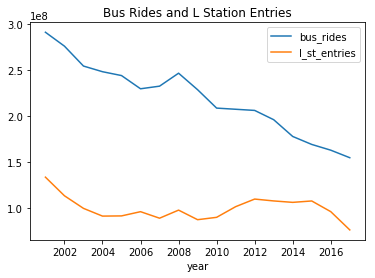

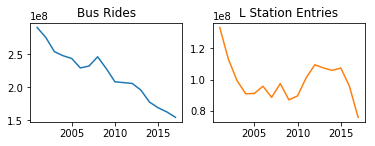

In [57]:
yearly_sums.plot(title='Bus Rides and L Station Entries') # plot the joined data

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
axes = [ax1, ax2]
colors = ['C0', 'C1']
titles = ['Bus Rides', 'L Station Entries']

# plot the separated data, to show difference in scaling
for ax, df, color, title in zip(axes, year_ride_sums, colors, titles):
    ax.plot(df,color=color)
    ax.set_title(title)

<h3>Bus Station Ridership per Route</h3>

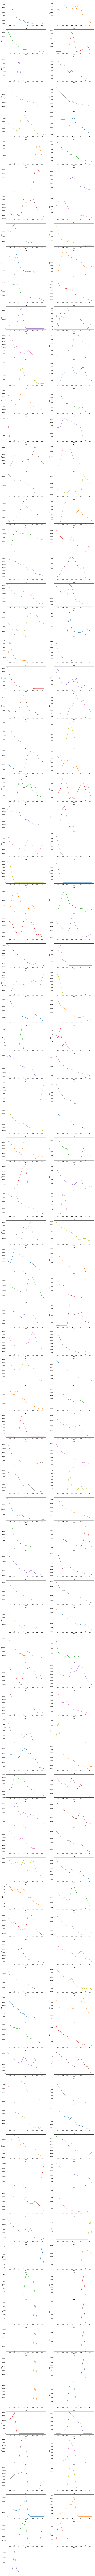

In [58]:
fig = plt.figure(figsize=(20, 600))
# fig.suptitle('Bus Ridership per Route')

for i, route in enumerate(routes_series_list):
    ax = fig.add_subplot(len(routes_series_list)/2 + 1, 2, i+1)
    ax.set_ylabel("rides")
    route.plot(title=route.name, ax=ax, color="C%s"%(i%9))

<h3>Bus Routes Totals</h3>

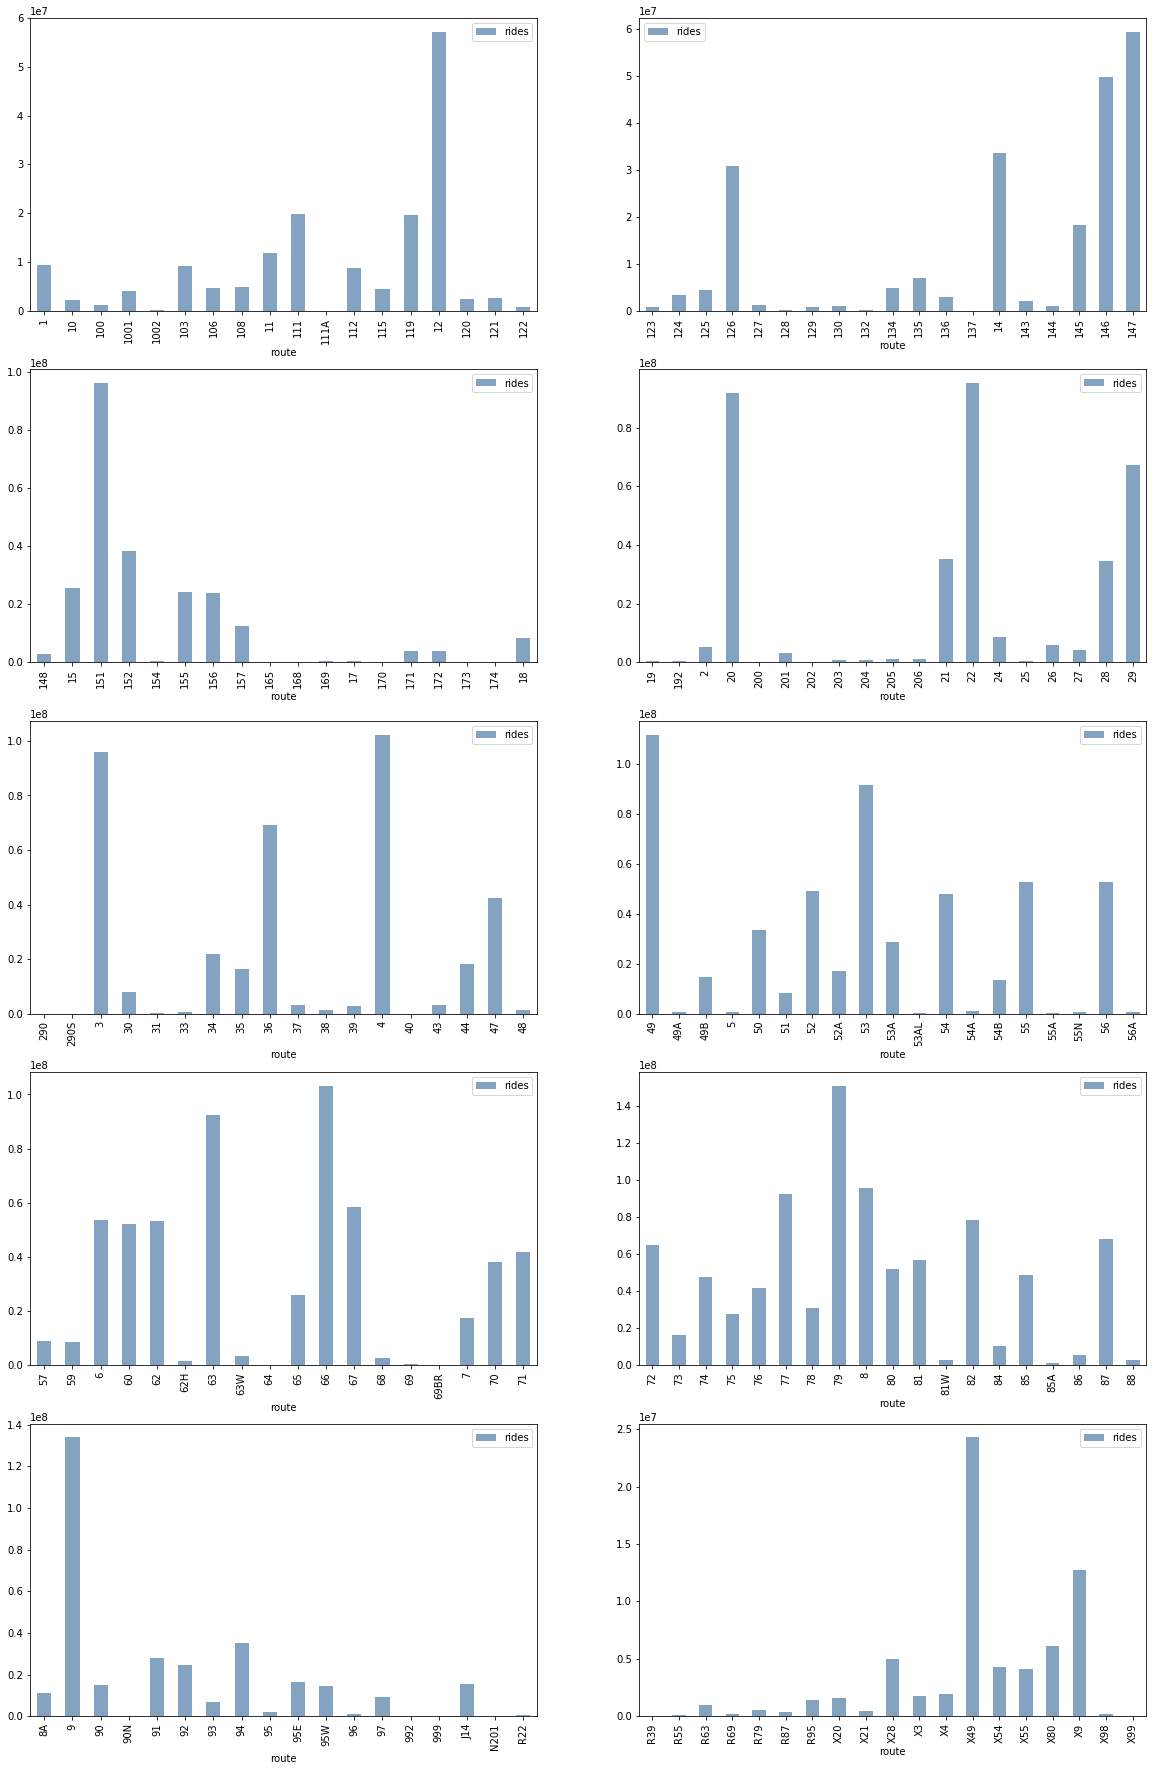

In [125]:
fig = plt.figure(figsize=(20, 600))

for i in range(len(routes_sums)/10):
    if routes_sums.iloc[i * len(routes_sums)/10 : (i + 1) * len(routes_sums)/10].empty:
        continue
    ax = fig.add_subplot(len(routes_sums)/2 + 1, 2, i+1)
    routes_sums.iloc[i * len(routes_sums)/10 : (i + 1) * len(routes_sums)/10].plot.bar(color=[(0.2, 0.4, 0.6, 0.6)], ax=ax)

<h3>El Station Totals</h3>

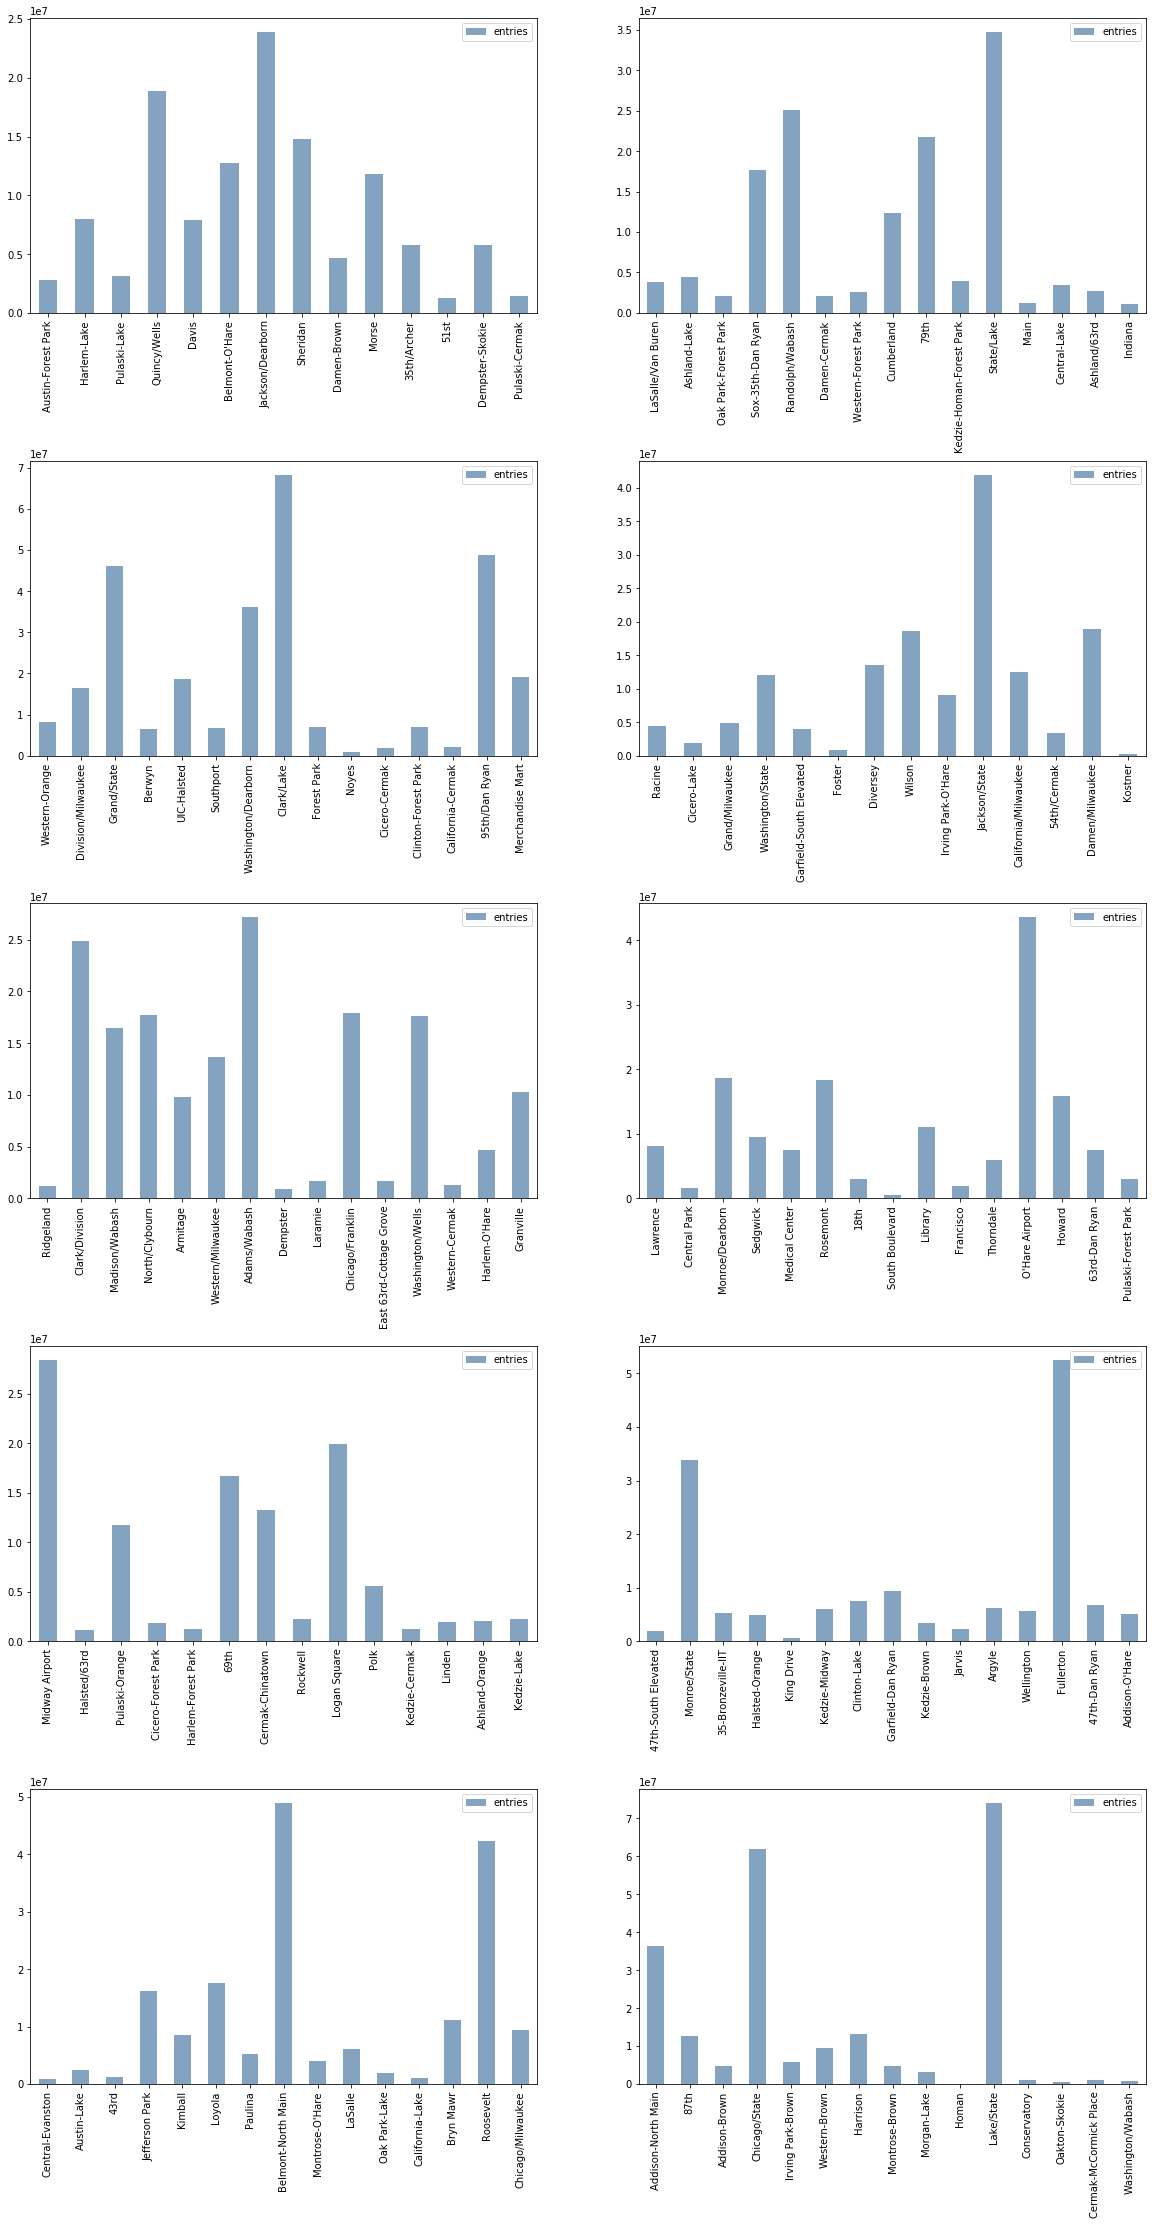

In [147]:
fig = plt.figure(figsize=(20, 600))
fig.subplots_adjust(hspace=.5)

for i in range(len(stations_sums)/10):
    if stations_sums.iloc[i * len(stations_sums)/10 : (i + 1) * len(stations_sums)/10].empty:
        continue
    ax = fig.add_subplot(len(stations_sums)/2 + 1, 2, i+1)
    stations_sums.iloc[i * len(stations_sums)/10 : (i + 1) * len(stations_sums)/10].plot.bar(color=[(0.2, 0.4, 0.6, 0.6)], ax=ax)

<h1>Conclusion</h1>
<p>Already, we can see some interesting trends in our data. For instance, it may have surprised you that CTA ridership is actually declining, with El ridership taking a steep drop after 2015. According to an article on CRAINS Chicago Business, this is due to the fact that rideshare services, such as Uber and Lyft are taking riders away from CTA. Here's a link to the article</p>

<a href="http://www.chicagobusiness.com/article/20180119/ISSUE05/180119872/whats-killing-cta-train-ridership-two-four-letter-words">What's killing CTA train ridership? Two four-letter words.</a>

<p>They infer this from the fact that they discovered CTA ridership was down on weekends and evenings. While I have not parsed the data in such a way, I believe this to be a plausible hypothesis, so I will trust that their assertion is correct. However, if you look at the chart showing bus and el ridership, you will see that ridership has been gradually declining since 2002, which is before these ridesharing services became popular. Therefore, there must be other factors influencing the decline. I hypothesize that this could potentially be due to increasing taxes and secondary effects of this driving more people out of the city and into the suburbs. To confirm this, hoever, I would need to do a regression that includes census data and data on tax increases in Chicago since 2002. This might be included in future work.</p>

<p>The next step in this project, however, is to gather data on vendor sales within the Greater Chicago area, to see if there is a relationship between CTA ridership and businesses, as that is the original intention of this project. Once that is completed, we can speculate as to why CTA ridership has been declining for so long. The data on vendor sales will be pre-processed in a similar manner to the data above.</p>